In [1]:
#pip install ydata-profiling

In [2]:
#!pip install imbalanced-learn

In [29]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from scipy import stats
from scipy.stats import normaltest
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
print(pd.__version__)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import pandas as pd
from sklearn.metrics import RocCurveDisplay
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

2.2.3


In [4]:
loan_data = pd.read_csv("loan_data.csv")

In [5]:
profile = ProfileReport(loan_data, title="Data Profile", explorative=True)
profile.to_notebook_iframe() 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 66.91it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#The percentage of loan vs. no loan
loan_counts = loan_data['loan_status'].value_counts(normalize = True) * 100
# Display the percentages
print(f"Percentage of loan not approved: {loan_counts[0]:.0f}%")
print(f"Percentage of loan approved: {loan_counts[1]:.0f}%")

Percentage of loan not approved: 78%
Percentage of loan approved: 22%


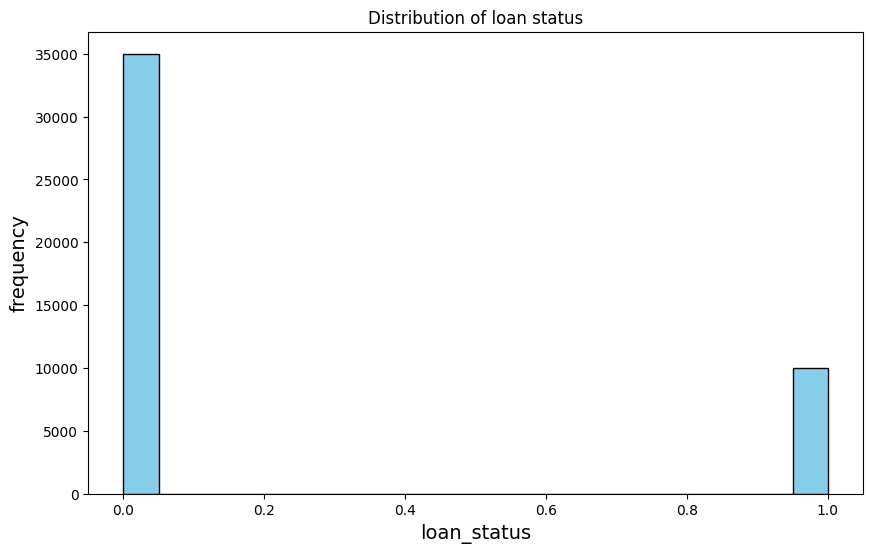

In [7]:
# Visualizing the distribution of our target
plt.figure(figsize = (10,6))
plt.hist(loan_data['loan_status'],bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of loan status')
plt.xlabel('loan_status', fontsize = 14)
plt.ylabel('frequency', fontsize = 14)

plt.show()

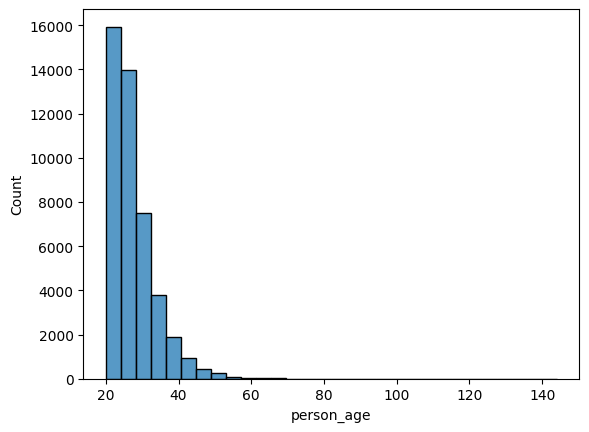

In [8]:
sns.histplot(loan_data['person_age'], bins = 30)
plt.show()

In [9]:
#filtering the outliers in age 
clean_load_data = loan_data[loan_data['person_age'] <= 90]
clean_load_data

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[44992 rows x 14 columns]

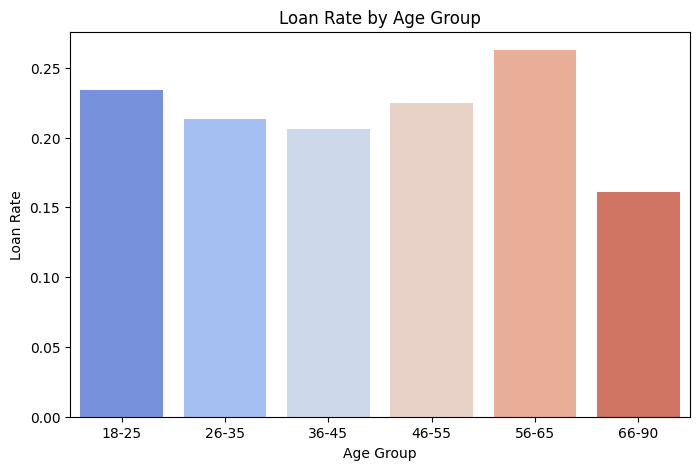

In [10]:
#which factor affects loan most 
#Age vs loan_status
bins = [18, 25, 35, 45, 55, 65, 90]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-90']
clean_load_data['Age Group'] = pd.cut(clean_load_data['person_age'], bins=bins, labels=labels)

# Calculate loan rate per age group
age_loan = clean_load_data.groupby('Age Group')['loan_status'].mean()

# Plot churn rate by age group
plt.figure(figsize=(8, 5))
sns.barplot(x=age_loan.index, y=age_loan.values, palette='coolwarm')
plt.title("Loan Rate by Age Group")
plt.ylabel("Loan Rate")
plt.show()

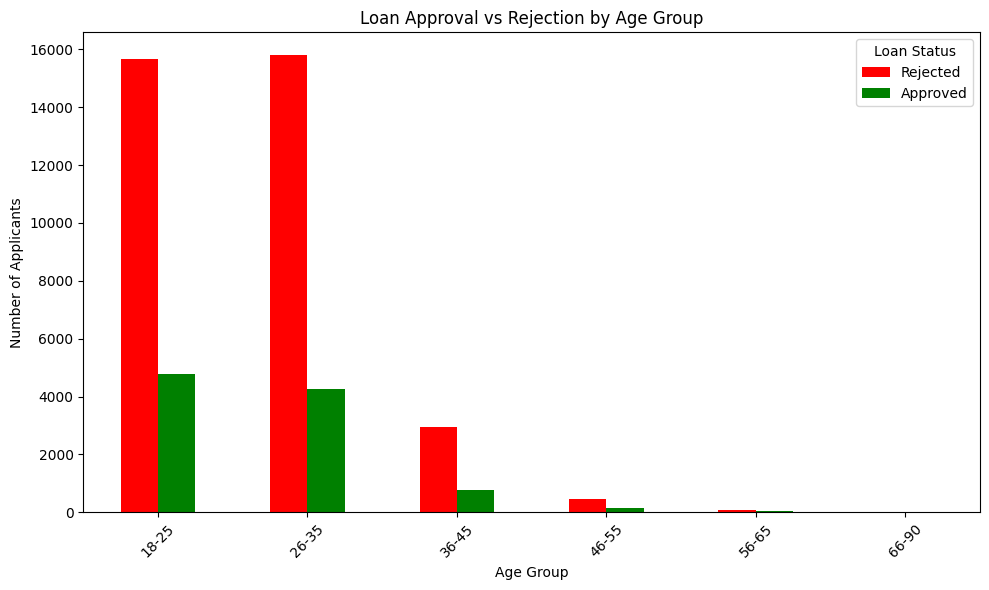

In [11]:
# Create Age Group column
clean_load_data['Age Group'] = pd.cut(clean_load_data['person_age'], bins=bins, labels=labels)

# Group by Age Group and loan_status, then count
grouped = clean_load_data.groupby(['Age Group', 'loan_status']).size().reset_index(name='count')

# Pivot to make loan_status values separate columns
pivot_df = grouped.pivot(index='Age Group', columns='loan_status', values='count').fillna(0)

# Optional: rename columns for clarity
pivot_df.columns = ['Rejected', 'Approved']  # loan_status 0 = rejected, 1 = approved

# Reset index for plotting
pivot_df = pivot_df.reset_index()

# Plotting
pivot_df.plot(x='Age Group', kind='bar', stacked=False, color=['red', 'green'], figsize=(10, 6))
plt.title('Loan Approval vs Rejection by Age Group')
plt.ylabel('Number of Applicants')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

['female' 'male']


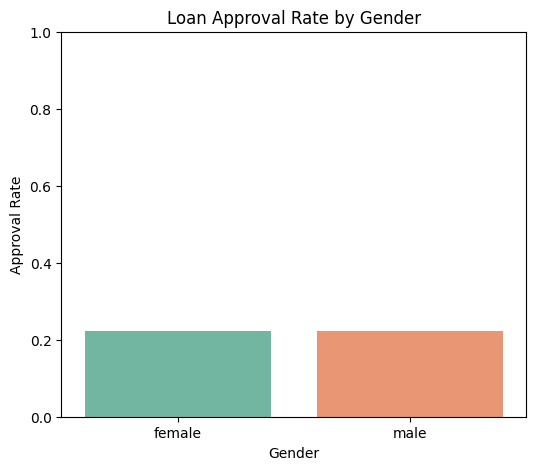

In [12]:
#How gender affects loan approval 
print(clean_load_data['person_gender'].unique())

loan_by_gender = clean_load_data.groupby('person_gender')['loan_status'].mean()

plt.figure(figsize = (6,5))
sns.barplot(x = loan_by_gender.index, y = loan_by_gender.values, palette = 'Set2')
plt.title('Loan Approval Rate by Gender')
plt.ylabel('Approval Rate')
plt.xlabel('Gender')
plt.ylim(0,1)
plt.show()

The approval rates for male and female applicants are almost identical, suggesting that gender does not have a substantial influence on loan decisions in this dataset.

Object `loan_rate` not found.


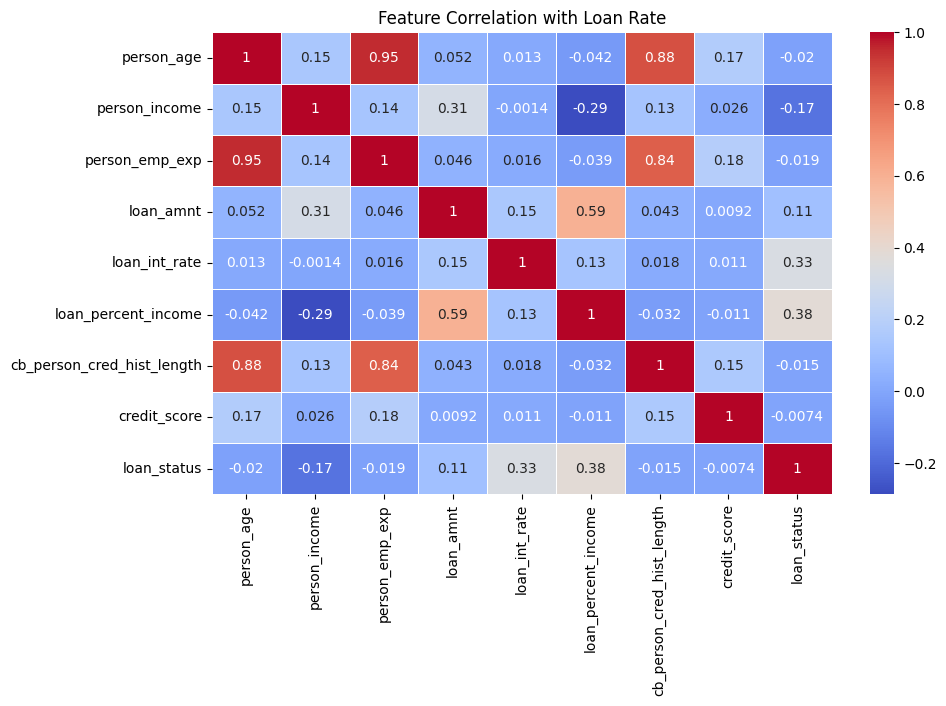

In [13]:
Which features are most correlated with loan_rate?
plt.figure(figsize=(10,6))
sns.heatmap(clean_load_data.select_dtypes(include=["number"]).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation with Loan Rate")
plt.show()

Most important features for predicting loan_status in this correlation matrix:
i.loan_percent_income (0.38)

ii.loan_int_rate (0.33)

iii.loan_amnt (0.11)

Least important / negligible:
age, employment experience, credit score, credit history length

In [14]:
#Feature Importance with Random Forest
#X = clean_load_data.drop(columns=['loan_status'])  # Features
#y = clean_load_data['loan_status']                # Target

# 2. Convert categorical variables (if any)
#X = pd.get_dummies(X, drop_first=True)

# 3. Split the dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest model
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

# 5. Get feature importances
#importances = rf.feature_importances_
#features = X.columns

# 6. Create DataFrame of importances
#feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
#feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 7. Plot feature importance
#plt.figure(figsize=(10, 6))
#sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature', palette='viridis')
#plt.title('Top 10 Feature Importances - Random Forest')
#plt.tight_layout()
#plt.show()


1.previous_loan_defaults_on_file_Yes (Most Important)
Meaning: Whether the applicant defaulted on a previous loan has the strongest influence on approval.
Makes sense — prior defaults are red flags in credit risk.

2.loan_percent_income
Definition: How much of a person's income goes toward repaying the loan.
A higher value likely means a riskier borrower, so this is a strong predictor.

3.loan_int_rate
Loan interest rate — the higher it is, the riskier the borrower appears.

4.person_income
Higher income likely increases chances of loan approval.

5.loan_amnt
The loan amount requested. Larger loans may be harder to approve unless well justified.

6.credit_score
Still important, but less so than defaults, income ratio, or interest rate — interesting insight!

7.person_home_ownership_RENT
Renters may be viewed as less stable than homeowners.

8.8–10. person_age, person_emp_exp, cb_person_cred_hist_length
These play a minor role, though still useful for context.

This reveals that credit history and affordability (not age or employment alone) are the biggest drivers of loan approval — a practical and explainable result in financial services.

In [15]:
#distribution of num cols
num_cols = ["person_income", "person_emp_exp", "Tenure", "Usage Frequency", "Support Calls", "Payment Delay", "Total Spend", "Last Interaction"]

In [16]:
#Feature selection/ 
#Feature engineering (on the entire dataset) - come back to it
#Split into training and test sets
#Handle class imbalance (on training data only)
#Train model
#Evaluate on untouched test data


In [17]:
#split into training and test sets
# Define features (X) and target variable (y)
X = clean_load_data.drop(columns=['loan_status', 'person_age']) #because we created Age Group above and CustomerID is just an identifier
y = clean_load_data['loan_status']

In [18]:
X

person_gender person_education  person_income  person_emp_exp  \
0            female           Master        71948.0               0   
1            female      High School        12282.0               0   
2            female      High School        12438.0               3   
3            female         Bachelor        79753.0               0   
4              male           Master        66135.0               1   
...             ...              ...            ...             ...   
44995          male        Associate        47971.0               6   
44996        female        Associate        65800.0              17   
44997          male        Associate        56942.0               7   
44998          male         Bachelor        33164.0               4   
44999          male      High School        51609.0               1   

      person_home_ownership  loan_amnt        loan_intent  loan_int_rate  \
0                      RENT    35000.0           PERSONAL          16.02   
1                       OWN     1000.0          EDUCATION          11.14   
2                  MORTGAGE     5500.0            MEDICAL          12.87   
3                      RENT    35000.0            MEDICAL          15.23   
4                      RENT    35000.0            MEDICAL          14.27   
...                     ...        ...                ...            ...   
44995                  RENT    15000.0            MEDICAL          15.66   
44996                  RENT     9000.0    HOMEIMPROVEMENT          14.07   
44997                  RENT     2771.0  DEBTCONSOLIDATION          10.02   
44998                  RENT    12000.0          EDUCATION          13.23   
44999                  RENT     6665.0  DEBTCONSOLIDATION          17.05   

       loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                     0.49                         3.0           561   
1                     0.08                         2.0           504   
2                     0.44                         3.0           635   
3                     0.44                         2.0           675   
4                     0.53                         4.0           586   
...                    ...                         ...           ...   
44995                 0.31                         3.0           645   
44996                 0.14                        11.0           621   
44997                 0.05                        10.0           668   
44998                 0.36                         6.0           604   
44999                 0.13                         3.0           628   

      previous_loan_defaults_on_file Age Group  
0                                 No     18-25  
1                                Yes     18-25  
2                                 No     18-25  
3                                 No     18-25  
4                                 No     18-25  
...                              ...       ...  
44995                             No     26-35  
44996                             No     36-45  
44997                             No     26-35  
44998                             No     26-35  
44999                             No     18-25  

[44992 rows x 13 columns]

In [19]:
y

0        1
1        0
2        1
3        1
4        1
        ..
44995    1
44996    1
44997    1
44998    1
44999    1
Name: loan_status, Length: 44992, dtype: int64

In [20]:
#Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [21]:
# Identify all numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Define preprocessing for numerical data (Imputation + Scaling)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Use median to handle outliers
    ('scaler', StandardScaler())  # Scale numerical features
])
# Define preprocessing for categorical data (Imputation + Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Convert categorical values to numeric
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Process all num cols
        ('cat', categorical_transformer, categorical_cols)  # Process all cat cols
    ]
)

In [22]:
# Fit and transform training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert to DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed)
X_test_transformed = pd.DataFrame(X_test_transformed)

# Print shape to verify transformation
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(40492, 26)
(4500, 26)


In [23]:
X_train_transformed

0         1         2         3         4         5         6   \
0     -0.085617 -0.911210  0.746868  0.100769  0.576350 -0.479525  0.107224   
1     -0.355543 -0.741530 -0.565935  0.221693 -0.456133 -0.738477 -0.131074   
2     -0.581620 -0.741530  2.005862  0.567671  4.362123 -0.738477  0.901553   
3     -0.166725  1.803668 -0.537764  0.013435 -0.570854  1.592085  1.894464   
4     -0.181110 -0.062811 -0.565935  1.420859 -0.570854 -0.479525  0.822120   
...         ...       ...       ...       ...       ...       ...       ...   
40487  0.135527 -0.911210 -0.407671 -0.137721 -0.685574 -0.997428  0.345523   
40488 -0.791383 -0.571850 -0.950201 -0.607982 -0.226693 -0.479525 -0.706963   
40489 -0.542734 -0.402171 -0.645067 -1.820583 -0.226693 -0.220574  0.782403   
40490  1.936409 -0.571850  1.649767  0.120923 -0.456133 -0.479525  0.385239   
40491  2.072478 -0.402171 -0.249406  0.047025 -1.144456 -0.479525  0.524247   

        7    8    9   ...   16   17   18   19   20   21   22   23   24   25  
0      0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
1      0.0  1.0  1.0  ...  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2      0.0  1.0  0.0  ...  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3      1.0  0.0  0.0  ...  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
4      1.0  0.0  1.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
40487  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
40488  1.0  0.0  1.0  ...  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  
40489  0.0  1.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  
40490  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  
40491  1.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  

[40492 rows x 26 columns]

In [24]:
#checking the class distribution in the training data
print(y_train.value_counts(normalize=True))

loan_status
0    0.777931
1    0.222069
Name: proportion, dtype: float64


In [25]:
#addressing imbalance
smote = SMOTE(random_state=42)

# Fit and resample only the training data
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)

# Check new class distribution
print(y_resampled.value_counts(normalize=True))

loan_status
0    0.5
1    0.5
Name: proportion, dtype: float64


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      3492
           1       0.63      0.91      0.75      1008

    accuracy                           0.86      4500
   macro avg       0.80      0.88      0.82      4500
weighted avg       0.89      0.86      0.87      4500

Confusion Matrix:
[[2953  539]
 [  88  920]]
 ROC AUC Score: 0.953


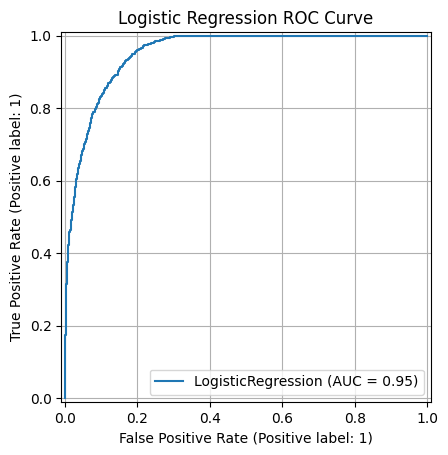

In [30]:
# 1. Initialize the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# 2. Fit the model
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_transformed)
y_proba = log_reg.predict_proba(X_test_transformed)[:, 1]

# 3. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f" ROC AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# 4. Plot ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_test_transformed, y_test)
plt.title("Logistic Regression ROC Curve")
plt.grid(True)
plt.show()